<a href="https://colab.research.google.com/github/daurensd/ml-zoomcamp/blob/main/04_evaluation_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [139]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [140]:
df = df[[
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]]
df

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500
...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920


In [141]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [142]:
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [143]:
df = df.fillna(0)

In [144]:
df.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [145]:
df['above_average'] = (df.msrp > df.msrp.mean()).astype(int)
del df['msrp']

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.above_average.values
y_val = df_val.above_average.values

del df_train['above_average']
del df_val['above_average']

In [62]:
for f in df_train.dtypes[df_train.dtypes != 'object'].index:
  print(f)

year
engine_hp
engine_cylinders
highway_mpg
city_mpg


In [25]:
# Question_1
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [65]:
for feature in df_train.dtypes[df_train.dtypes != 'object'].index:
    print(feature)

    y_pred = df_train[feature].values
    thresholds = np.linspace(y_pred.min(), y_pred.max(), 21)

    scores = []
    best_t = 0
    best_score = 0
    for t in thresholds:
        score = accuracy_score(y_train, y_pred >= t)
        # print('%.2f %.3f' % (t, score))
        scores.append(score)
        if score > best_score:
            best_score = score
            best_t = t
    # print(best_t, best_score)

    y_pred = (y_pred >= best_t).astype(int)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    print('auc:', auc(fpr, tpr))

year
auc: 0.5412015373796243
engine_hp
auc: 0.8140090490334212
engine_cylinders
auc: 0.6821317811693173
highway_mpg
auc: 0.5002560163850487
city_mpg
auc: 0.5005120327700973


In [149]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)
categorical

['make', 'model', 'transmission_type', 'vehicle_style']

In [150]:
numerical = list(df_train.dtypes[df_train.dtypes != 'object'].index)
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [73]:
# Question_2
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [74]:
dv, model = train(df_train, y_train, C=1.0)

In [75]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [76]:
y_pred = predict(df_val, dv, model)

In [82]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
print('auc:', round(auc(fpr, tpr), 3))

auc: 0.98


In [91]:
# Question_3

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    # p = tp / (tp + fp)
    # r = tp / (tp + fn)

    scores.append((t, tp, fp, fn, tn))

In [92]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

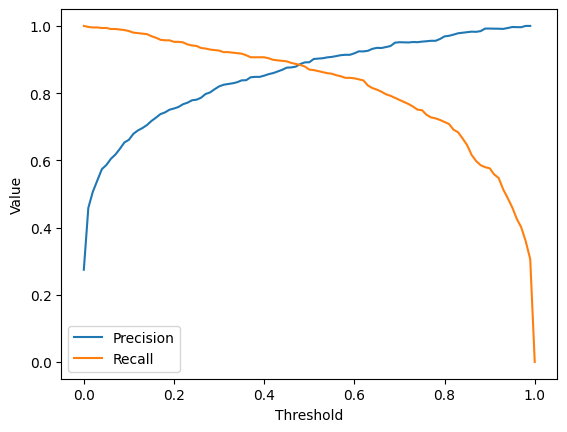

In [104]:
plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')

plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()

In [109]:
df_scores[round(df_scores.p, 1) == round(df_scores.r, 1)]

,threshold,tp,fp,fn,tn,p,r
40,0.40,593,103,61,1626,0.852011,0.906728
41,0.41,591,99,63,1630,0.856522,0.903670
42,0.42,588,96,66,1633,0.859649,0.899083
43,0.43,587,92,67,1637,0.864507,0.897554
44,0.44,586,88,68,1641,0.869436,0.896024
45,0.45,585,83,69,1646,0.875749,0.894495
46,0.46,582,82,72,1647,0.876506,0.889908
47,0.47,580,80,74,1649,0.878788,0.886850
48,0.48,578,74,76,1655,0.886503,0.883792
49,0.49,575,70,79,1659,0.891473,0.879205


In [110]:
# Question_4

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [112]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['F1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [114]:
df_scores[df_scores['F1'] == df_scores['F1'].max()]

,threshold,tp,fp,fn,tn,p,r,F1
49,0.49,575,70,79,1659,0.891473,0.879205,0.885296


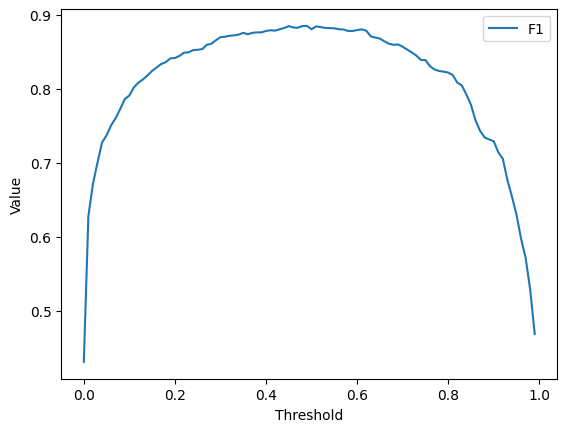

In [115]:
plt.plot(df_scores.threshold, df_scores['F1'], label='F1')

plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()

In [155]:
# Question_5

from sklearn.model_selection import KFold
from sklearn.metrics import auc

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [161]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

scores = []
X = df_train_full
y = df_train_full.above_average
del X['above_average']

kf = KFold(n_splits=5, shuffle=True, random_state=1)
for num, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    dv, model = train(X_train, y_train, C=1.0)

    y_pred = predict(X_val, dv, model)

    fpr, tpr, thresholds = roc_curve(y_val, y_pred)

    scores.append(auc(fpr, tpr))
print(scores)
print('std:', np.std(scores))

[0.9784891235596622, 0.9802029731275015, 0.9829025151971447, 0.9772586581897273, 0.9776862026862028]
std: 0.002060199182252492


In [166]:
# Question_6

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

X = df_train_full
y = df_train_full.above_average
del X['above_average']

best_c = 0
best_score = 0

for C in [0.01, 0.1, 0.5, 10]:
    print('C:', C)
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    for num, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        dv, model = train(X_train, y_train, C=C)

        y_pred = predict(X_val, dv, model)

        fpr, tpr, thresholds = roc_curve(y_val, y_pred)

        scores.append(auc(fpr, tpr))

    print('mean:', round(np.mean(scores), 3))
    print('std:', round(np.std(scores), 3))

C: 0.01
mean: 0.952
std: 0.003
C: 0.1
mean: 0.972
std: 0.002
C: 0.5
mean: 0.977
std: 0.002
C: 10
mean: 0.981
std: 0.003
